# QM Wavepacket scattering off potential


We will compute a solution to the Schroedinger equation of an initial Gaussian wavepacket traveling with constant velocity to the right of our simulation, which interacts with a given potential function. 

We will consider two potentials: 
- a square well
$$ \begin{align} V(x) & = V_0 & |x| < \Delta/2 \\ & = 0 & \mathrm{otherwise} \end{align} $$
- a Gaussian potential
$$ V(x) = V_0 \exp\left(-\frac{(x-x_0)^2}{2\sigma^2}\right) $$


We will two solutions. The first will use the [Crank-Nicholson scheme](https://en.wikipedia.org/wiki/Crank–Nicolson_method) as a "stepper" method that has the property of conserving probability. This utilizes the tridiagonal matrix inversion techniques we have used earlier in the semester. We will impose Dirichlet boundary conditions in this case for simplicity. 

We will also solve the problem in the Fourier domain as a seperate strategy. In this case we will impose periodic boundary conditions for simplicity. 


In [1]:
import numpy as np
import time
import matplotlib
from matplotlib import animation, rc
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import cmath
from scipy.sparse import diags, linalg

class Wavepacket : 

    def __init__(self, N=600, L=100., dt=0.1, gaussian=False):

        self.h_bar = 1.0             # Planck's constant / 2pi in natural units
        self.mass = 1.0              # particle mass in natural units

        # The spatial grid
        self.N = N                   # number of interior grid points
        self.L = L                   # system extends from x = 0 to x = L
        self.dx = L / float(N + 1)   # grid spacing
        self.dt = dt                 # time step

        # The potential V(x)
        self.V_0 = 0.5               # height of potential barrier
        self.V_width = 10.0          # width of potential barrier
        self.V_center = 0.75 * L     # center of potential barrier
        self.gaussian = gaussian     # True = Gaussian potential, False = step potential


        # Initial wave packet
        self.x_0 = L / 4.0           # location of center
        self.E = 1.0                 # average energy
        self.sigma_0 = L / 10.0      # initial width of wave packet
        self.psi_norm = 1.0          # norm of psi
        self.k_0 = 0.0               # average wavenumber
        self.velocity = 0.0          # average velocity
        self.t = 0.0                 # time
        self.psi = np.zeros(N, dtype=complex) # complex wavefunction        
        self.x = np.arange(self.N) * self.dx # vector of grid points

        # initialize the packet
        self.k_0 = np.sqrt(2*self.mass*self.E - self.h_bar**2 / 2 / self.sigma_0**2) / self.h_bar
        self.velocity = self.k_0 / self.mass
        self.psi_norm = 1 / np.sqrt(self.sigma_0 * np.sqrt(np.pi))
        exp_factor = np.exp( - (self.x - self.x_0)**2 / (2 * self.sigma_0**2))
        # Wavefunction: 
        self.psi = (np.cos(self.k_0 * self.x) + 1j * np.sin(self.k_0 * self.x)) * exp_factor * self.psi_norm
        # wavefunction for simplified Crank-Nicholson : 
        self.chi = np.zeros(N, dtype=complex)

        # elements of tridiagonal matrix Q = (1/2)(1 + i dt H / (2 hbar))
        self.a = np.full( self.N-1, - 1j * self.dt * self.h_bar / (8 * self.mass * self.dx**2) )
        self.b = 0.5 + 1j * self.dt / (4 * self.h_bar) * (self.V(self.x) + self.h_bar**2 / (self.mass * self.dx**2))
        self.c = np.full( self.N-1, - 1j * self.dt * self.h_bar / (8 * self.mass * self.dx**2) )

    def V(self, x):
        half_width = np.absolute(0.5 * self.V_width)
        if self.gaussian:
            return self.V_0 * np.exp(-(x - self.V_center)**2 / (2 * half_width**2))
        else:
            return np.where( np.absolute(x - self.V_center) <= half_width, self.V_0, 0.0)


    def step_psi(self):
        T = diags([ self.b, self.a, self.c], [0,-1,1], format = 'csc')
        chi = linalg.spsolve(T,self.psi)
        self.psi = chi - self.psi
        return self.psi
        
class WavepacketFFT( Wavepacket) : 

    def __init__( self, N=128, L=100., dt=0.1 ):
        Wavepacket.__init__(self, N,L,dt)
        # precomputed phase rotation from kinetic energy
        self.T_exp_factor = np.zeros(N,dtype=complex)
        # precomputed phase rotation from kinetic energy
        self.V_exp_factor = np.zeros(N,dtype=complex)
        # initialize the phase rotation factors
        j = np.arange(N)
        p = np.where( j < N//2, j, j-N) * self.h_bar * 2 * np.pi/L        
        theta = - p**2 / (2 * self.mass) / self.h_bar * self.dt
        self.T_exp_factor = np.cos(theta) + 1j * np.sin(theta)
        # potential factor exp[-iV(x)/(2h_bar) dt]
        theta = - self.V(self.x) / 2.0 / self.h_bar * self.dt
        self.V_exp_factor = np.cos(theta) + 1j * np.sin(theta)


    def step_psi(self ):
        # first half of potential phase rotation
        self.psi *= self.V_exp_factor
        # FFT to momentum space
        psik = np.fft.fft(self.psi)
        # kinetic phase rotation
        psik *= self.T_exp_factor
        # FFT back to position space
        self.psi = np.fft.ifft(psik)
        # second half of potential phase rotation
        self.psi *= self.V_exp_factor
        self.t += self.dt
        return self.psi

In [3]:
class Animator(object):

    def __init__(self, wavepacket=None):
        self.avg_times = []
        self.wavepacket = wavepacket       
        self.t = 0.
        self.fig, self.ax = plt.subplots()

        self.myline = plt.axvline( x=(self.wavepacket.V_center - 0.5 * self.wavepacket.V_width)/ self.wavepacket.dx,
                                   color='r'
            )
        self.myline = plt.axvline( x=(self.wavepacket.V_center + 0.5 * self.wavepacket.V_width)/ self.wavepacket.dx,
                                   color='r'
            )
        self.ax.set_ylim(0,0.5)
        initvals = self.wavepacket.psi
        self.line, = self.ax.plot(initvals)
        self.ani = animation.FuncAnimation( self.fig,        # Animate our figure
                                            self.update,     # Update function draws our data
                                            self.time_step,  # "frames" function does the time step, each iteration
                                            interval=10,     # 50 ms between iterations
                                            blit=False       # don't blit anything
                                            )

    def update(self, data) :
        self.line.set_ydata(data)
        return self.line,
        
    def time_step(self):
        while True :
            self.wavepacket.psi = self.wavepacket.step_psi()
            self.t += self.wavepacket.dt;
            yield np.absolute(self.wavepacket.psi)

<IPython.core.display.Javascript object>


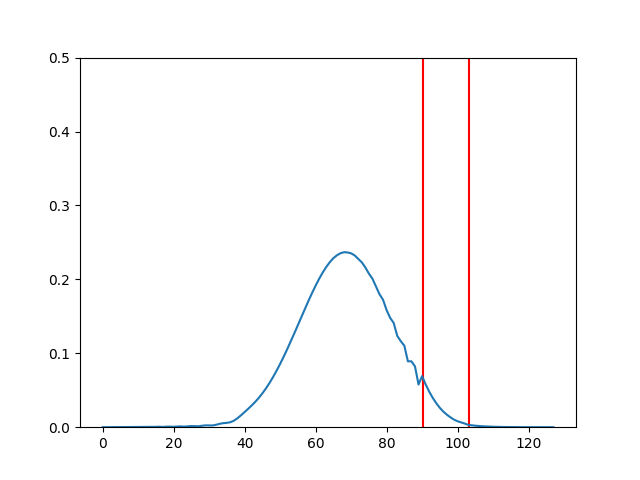

In [6]:
%matplotlib notebook
wavepacket = Wavepacket(N=128)
animator = Animator(wavepacket=wavepacket)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


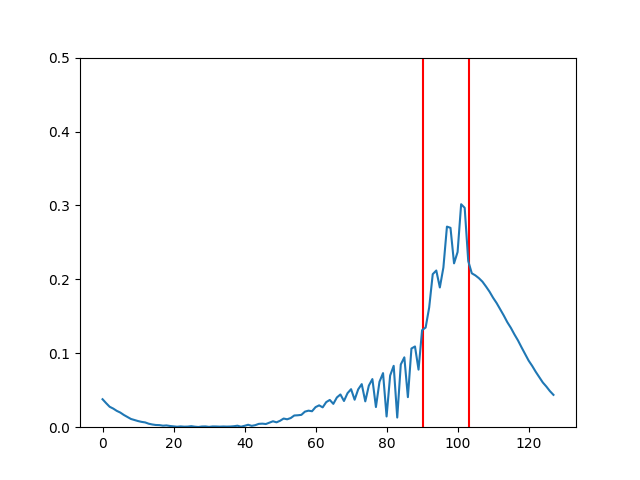

In [5]:
%matplotlib notebook
wavepacketFFT = WavepacketFFT(N=128)
animator = Animator(wavepacket=wavepacketFFT)